In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, trim, lower, count, desc, when, split, size
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import squarify


spark = SparkSession.builder.appName("LinkedIn Data Analysis")\
.getOrCreate()

json_file_path = "linked_data.json"

linkedin_df = spark.read.json(json_file_path, multiLine=True)

linkedin_df.printSchema()
linkedin_df.show(5, truncate=False)


root
 |-- certifications: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- authority: string (nullable = true)
 |    |    |-- display_source: string (nullable = true)
 |    |    |-- ends_at: struct (nullable = true)
 |    |    |    |-- day: long (nullable = true)
 |    |    |    |-- month: long (nullable = true)
 |    |    |    |-- year: long (nullable = true)
 |    |    |-- license_number: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- starts_at: struct (nullable = true)
 |    |    |    |-- day: long (nullable = true)
 |    |    |    |-- month: long (nullable = true)
 |    |    |    |-- year: long (nullable = true)
 |    |    |-- url: string (nullable = true)
 |-- city: string (nullable = true)
 |-- connections: long (nullable = true)
 |-- country_full_name: string (nullable = true)
 |-- education: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- degree_name: string (null

In [10]:
education_flat_df = linkedin_df.withColumn("education", explode(col("education")))

education_flat_df = education_flat_df.select(
    trim(lower(col("education.school"))).alias("school"),
    trim(lower(col("education.field_of_study"))).alias("field_of_study"),
    trim(lower(col("education.degree_name"))).alias("degree_name")
)


In [11]:
def SetDegree(education_flat_df):
    return education_flat_df.withColumn(
    "degree_name",
    when(
        col("degree_name").like("%bachelor of technology%") | 
        col("degree_name").like("%btech%") | 
        col("degree_name").like("%técnico%") | 
        col("degree_name").like("%b.tech%"), 
        "bachelor of technology"
    )
    .when(
        col("degree_name").like("%bachelor of science%") | 
        col("degree_name").like("%bsc%") | 
        col("degree_name").like("%bs%") |
        col("degree_name").like("%b.s%"), 
        "bachelor of science"
    )
    .when(
        col("degree_name").like("%bachelor of business administration%") | 
        col("degree_name").like("%bba%"), 
        "Bachelor of business administration"
    )
    .when(
        col("degree_name").like("%master of business administration%") | 
        col("degree_name").like("%mba%"), 
        "master of business administration"
    )
    .when(
        col("degree_name").like("%bachelor of arts%") | 
        col("degree_name").like("%b.a%")|
        col("degree_name").like("%ba%")& ~col("degree_name").like("%mba%") &~col("degree_name").like("%bachelor%"),
        "bachelor of arts"
    )
    .when(
        col("degree_name").like("%master of science%") | 
        col("degree_name").like("%msc%") | 
        col("degree_name").like("%m.s%") | 
        col("degree_name").like("%ms%"), 
        "master of science"
    )
    .when(
        col("degree_name").like("%master of arts%") | 
        col("degree_name").like("%ma%") & ~col("degree_name").like("%master%") | 
        col("degree_name").like("%m.a%"), 
        "master of arts"
    )
    .when(
        col("degree_name").like("%master of engineering%") | 
        col("degree_name").like("%me%") | 
        col("degree_name").like("%m.e.%"), 
        "master of engineering"
    )
    .when(
        col("degree_name").like("%bachelor of engineering%") | 
        col("degree_name").like("%bacharelado em engenharia%") | 
        col("degree_name").like("%be%") | 
        col("degree_name").like("%engineering%") | 
        col("degree_name").like("%b.e.%"), 
        "bachelor of engineering"
    )
    .when(
        col("degree_name").like("%master of technology%") | 
        col("degree_name").like("%mtech%") | 
        col("degree_name").like("%m.tech%"), 
        "master of technology"
    )
    .when(
        col("degree_name").like("%master%") & ~col("degree_name").like("%science%") & ~col("degree_name").like("%arts%") & ~col("degree_name").like("%engineering%") & ~col("degree_name").like("%technology%"), 
        "master's degree"
    )
    .when(
        col("degree_name").like("%bachelor%") & ~col("degree_name").like("%science%") & ~col("degree_name").like("%arts%") & ~col("degree_name").like("%engineering%") & ~col("degree_name").like("%technology%")| 
        col("degree_name").like("%bacharelado%"),
        "bachelor's degree"
    )
    .when(
        col("degree_name").like("%phd%") | 
        col("degree_name").like("%ph.d%"), 
        "phd"
    )
    .when(
        col("degree_name").like("%high%") |
        col("degree_name").like("%graduação%") |
        col("degree_name").like("%school%") ,
        "high school"
    )
    .when(
        col("degree_name").like("%aa%")|
        col("degree_name").like("%a.a%"),
        "associate of arts"
    )
    .when(
        col("degree_name").like("%as%")|
        col("degree_name").like("%as.%")|
        col("degree_name").like("%associate of science%"),
        "associate of science"
    )
    .when(
        col("degree_name").like("%graduate%"),
        "graduate"
    )
    .otherwise(col("degree_name")) 
)

In [12]:
education_flat_df  = education_flat_df.withColumn(
    "degree_name",
    when(
        col("degree_name").like("%bachelor of technology%") | 
        col("degree_name").like("%btech%") | 
        col("degree_name").like("%técnico%") | 
        col("degree_name").like("%b.tech%"), 
        "bachelor of technology"
    )
    .when(
        col("degree_name").like("%bachelor of science%") | 
        col("degree_name").like("%bsc%") | 
        col("degree_name").like("%bs%") |
        col("degree_name").like("%b.s%"), 
        "bachelor of science"
    )
    .when(
        col("degree_name").like("%bachelor of business administration%") | 
        col("degree_name").like("%bba%"), 
        "Bachelor of business administration"
    )
    .when(
        col("degree_name").like("%master of business administration%") | 
        col("degree_name").like("%mba%"), 
        "master of business administration"
    )
    .when(
        col("degree_name").like("%bachelor of arts%") | 
        col("degree_name").like("%b.a%")|
        col("degree_name").like("%ba%")& ~col("degree_name").like("%mba%") &~col("degree_name").like("%bachelor%"),
        "bachelor of arts"
    )
    .when(
        col("degree_name").like("%master of science%") | 
        col("degree_name").like("%msc%") | 
        col("degree_name").like("%m.s%") | 
        col("degree_name").like("%ms%"), 
        "master of science"
    )
    .when(
        col("degree_name").like("%master of arts%") | 
        col("degree_name").like("%ma%") & ~col("degree_name").like("%master%") | 
        col("degree_name").like("%m.a%"), 
        "master of arts"
    )
    .when(
        col("degree_name").like("%master of engineering%") | 
        col("degree_name").like("%me%") | 
        col("degree_name").like("%m.e.%"), 
        "master of engineering"
    )
    .when(
        col("degree_name").like("%bachelor of engineering%") | 
        col("degree_name").like("%bacharelado em engenharia%") | 
        col("degree_name").like("%be%") | 
        col("degree_name").like("%engineering%") | 
        col("degree_name").like("%b.e.%"), 
        "bachelor of engineering"
    )
    .when(
        col("degree_name").like("%master of technology%") | 
        col("degree_name").like("%mtech%") | 
        col("degree_name").like("%m.tech%"), 
        "master of technology"
    )
    .when(
        col("degree_name").like("%master%") & ~col("degree_name").like("%science%") & ~col("degree_name").like("%arts%") & ~col("degree_name").like("%engineering%") & ~col("degree_name").like("%technology%"), 
        "master's degree"
    )
    .when(
        col("degree_name").like("%bachelor%") & ~col("degree_name").like("%science%") & ~col("degree_name").like("%arts%") & ~col("degree_name").like("%engineering%") & ~col("degree_name").like("%technology%")| 
        col("degree_name").like("%bacharelado%"),
        "bachelor's degree"
    )
    .when(
        col("degree_name").like("%phd%") | 
        col("degree_name").like("%ph.d%"), 
        "phd"
    )
    .when(
        col("degree_name").like("%high%") |
        col("degree_name").like("%graduação%") |
        col("degree_name").like("%school%") ,
        "high school"
    )
    .when(
        col("degree_name").like("%aa%")|
        col("degree_name").like("%a.a%"),
        "associate of arts"
    )
    .when(
        col("degree_name").like("%as%")|
        col("degree_name").like("%as.%")|
        col("degree_name").like("%associate of science%"),
        "associate of science"
    )
    .when(
        col("degree_name").like("%graduate%"),
        "graduate"
    )
    .otherwise(col("degree_name")) 
)

In [13]:
def SetFields(education_flat_df):
    return education_flat_df.withColumn(
        "field_of_study",
        when(
            col("field_of_study").like("%finance%") | 
            col("field_of_study").like("%accounting%") | 
            col("field_of_study").like("%accounts%"), 
            "finance and accounting"
        )
        .when(
            col("field_of_study").like("%web development%") | 
            col("field_of_study").like("%software developement%")|
            col("field_of_study").like("%software development%")|
            col("field_of_study").like("%computer science%") | 
            col("field_of_study").like("%computer engineering%"),
            "computer engineering and developement"
        )
        .when(
            col("field_of_study").like("%data%")|
            col("field_of_study").like("%learning%"),
            "Data science and Machine Learning"
        )
        .when(
            col("field_of_study").like("%electrical%") | 
            col("field_of_study").like("%electronics%")|
            col("field_of_study").like("%electric%") | 
            col("field_of_study").like("%electronic%"),
            "electrical and electronics"
        )
        .when(
            col("field_of_study").like("%political%") |
            col("field_of_study").like("%politics%"),
            "political science"
        )
        .when(
            col("field_of_study").like("%human resources%")|
            col("field_of_study").like("%hr%"),
            "human resources"
        )
        .when(
            col("field_of_study").like("%marketing%")|
            col("field_of_study").like("%sales%"),
            "marketing and sales"
        )
        .when(
            col("field_of_study").like("%management%"),
            "business management"
        )
        .when(
            col("field_of_study").like("%literature%"),
            "literature"
        )
        .when(
            col("field_of_study").like("%health%")|
            col("field_of_study").like("%medical%")|
            col("field_of_study").like("%medicine%"),
            "medical"
        )
        .when(
            col("field_of_study").like("%biology%")|
            col("field_of_study").like("%biological%"),
            "biology"
        )
        .when(
            col("field_of_study").like("%mathematics%")|
            col("field_of_study").like("%maths%"),
            "mathematics"
        )
        .when(
            col("field_of_study").like("%physics%"),
            "physics"
        )
        .when(
            col("field_of_study").like("%economics%"),
            "economics"
        )
        .when(
            col("field_of_study").like("%information system%")|
            col("field_of_study").like("%information technology%")|
            col("field_of_study").like("%technology%"),
            "information technology"
        )
        .when(
            col("field_of_study").like("%media%")|
            col("field_of_study").like("%communication%"),
            "media and communication"
        )   
        .when(
            col("field_of_study").like("%language%")|
            col("field_of_study").like("%french%")|
            col("field_of_study").like("%japanese%")|
            col("field_of_study").like("%spanish%"),
            "language and linguistics"
        )
        .when(
            col("field_of_study").like("%financial%"),
            "financial study"
        )
        .when(
            col("field_of_study").like("%education%"),
            "education"
        )
        .when(
            col("field_of_study").like("%industrial%"),
            "industrial developement and engineering"
        )
        .when(
            col("field_of_study").like("%music%"),
            "music"
        )
        .when(
            col("field_of_study").like("%law%")|
            col("field_of_study").like("%justice%")|
            col("field_of_study").like("%legal%"),
            "law"
        )
        .when(
            col("field_of_study").like("%art%")|
            col("field_of_study").like("%arts%")|
            col("field_of_study").like("%science%"),
            "arts and science"
        )
        .otherwise(col("field_of_study")) 
    )

C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\3252691150.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=degree_count_pd, x="count", y="degree_name", palette="coolwarm")


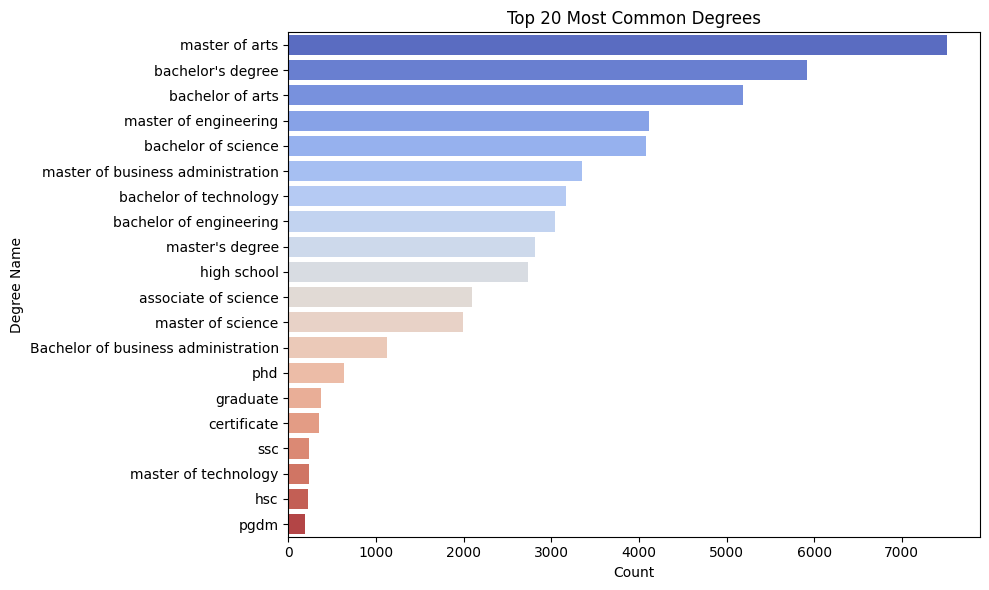

C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\3252691150.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=field_count_pd, x="count", y="field_of_study", palette="viridis")


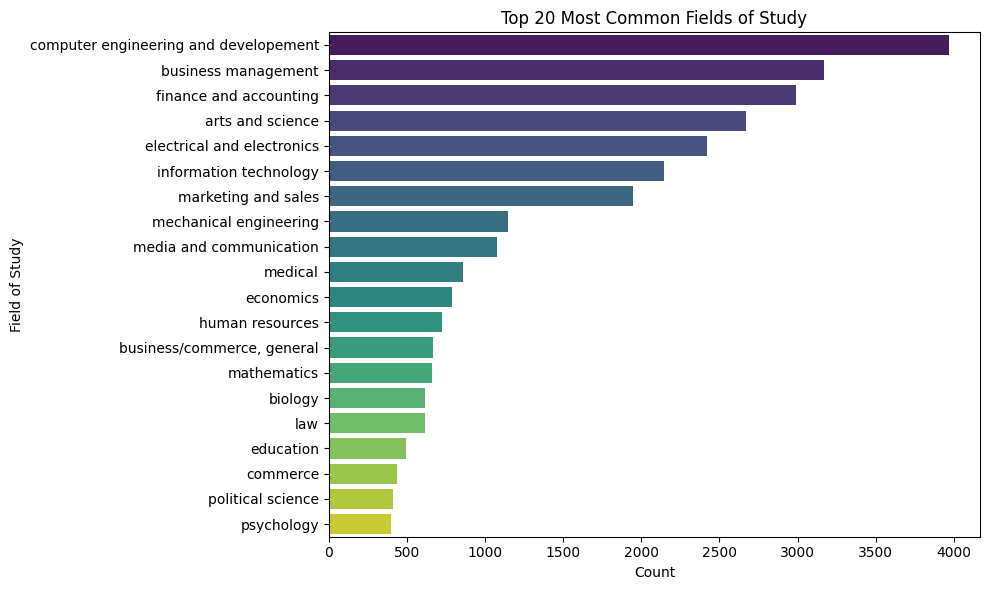

C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\3252691150.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=school_count_pd, x="count", y="school", palette="cubehelix")


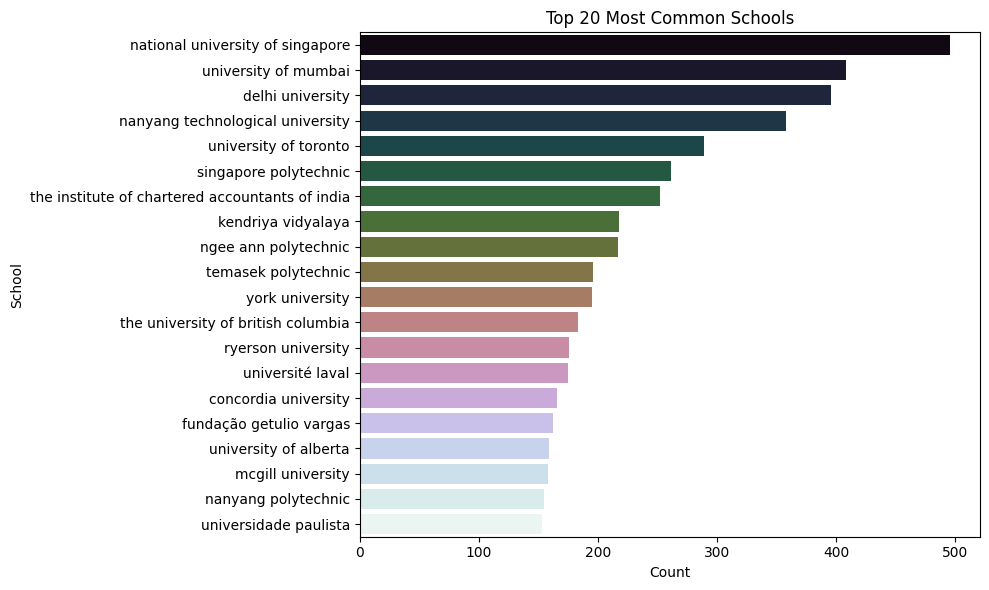

In [19]:
degree_count = education_flat_df.groupBy("degree_name").agg(count("degree_name").alias("count")).orderBy(desc("count"))
degree_count_pd = degree_count.limit(20).toPandas()



education_flat_df =  education_flat_df.filter(
    col("school").isNotNull() & (col("school") != "") & (col("school") != "{}")
)

education_flat_df =  SetFields(education_flat_df)
education_flat_df =  SetDegree(education_flat_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=degree_count_pd, x="count", y="degree_name", palette="coolwarm")
plt.title("Top 20 Most Common Degrees")
plt.xlabel("Count")
plt.ylabel("Degree Name")
plt.tight_layout()
plt.show()

field_count = education_flat_df.groupBy("field_of_study").agg(count("field_of_study").alias("count")).orderBy(desc("count"))
field_count_pd = field_count.limit(20).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=field_count_pd, x="count", y="field_of_study", palette="viridis")
plt.title("Top 20 Most Common Fields of Study")
plt.xlabel("Count")
plt.ylabel("Field of Study")
plt.tight_layout()
plt.show()

school_count = education_flat_df.groupBy("school").agg(count("school").alias("count")).orderBy(desc("count"))
school_count_pd = school_count.limit(20).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=school_count_pd, x="count", y="school", palette="cubehelix")
plt.title("Top 20 Most Common Schools")
plt.xlabel("Count")
plt.ylabel("School")
plt.tight_layout()
plt.show()


C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\3652959353.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=company_count_pd, x="count", y="company", palette="coolwarm")


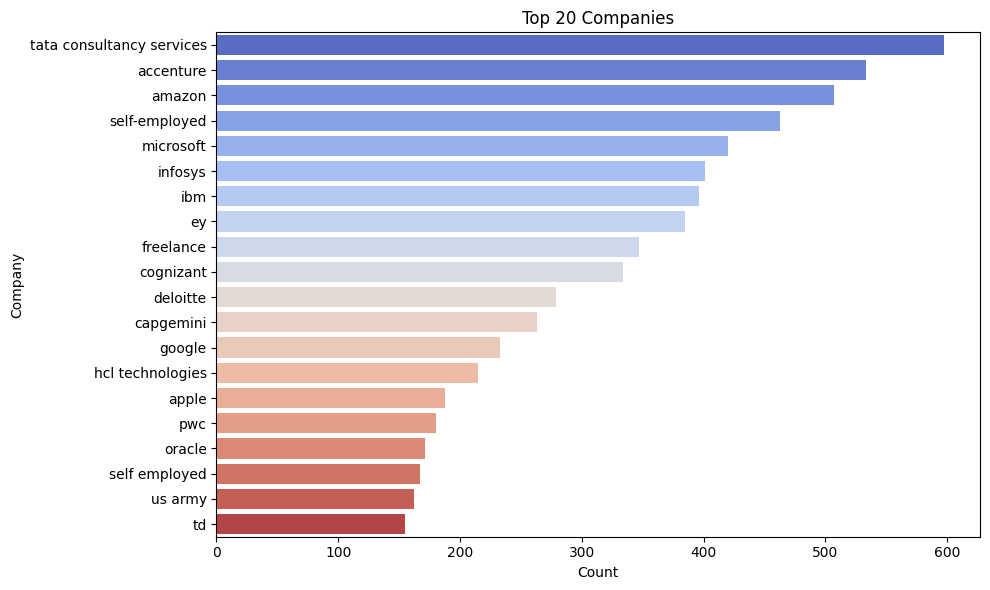

C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\3652959353.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=title_count_pd, x="count", y="title", palette="plasma")


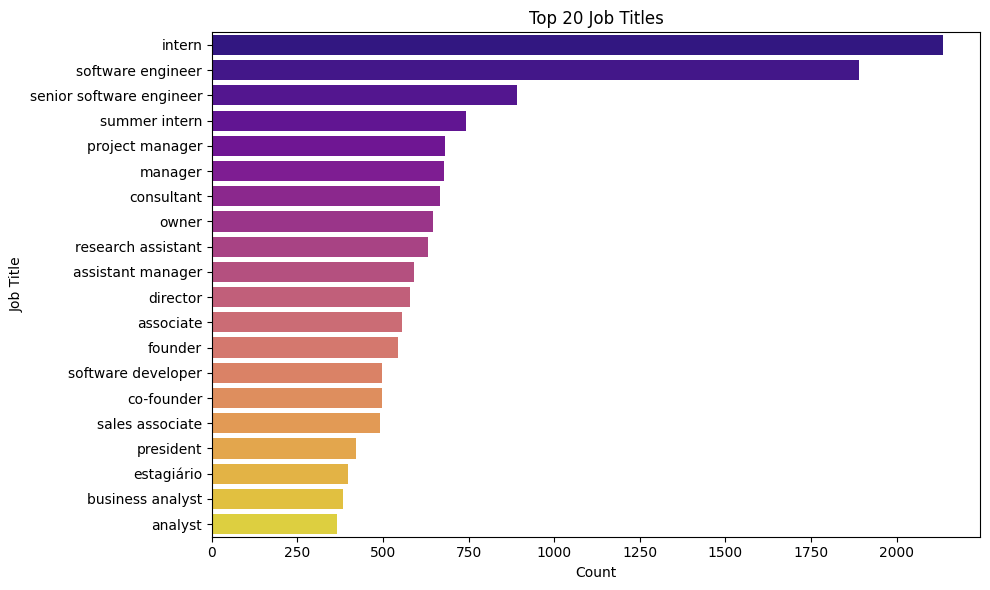

In [21]:
experience_flat_df = linkedin_df.withColumn("experiences", explode(col("experiences")))
experience_flat_df = experience_flat_df.select(
    trim(lower(col("experiences.company"))).alias("company"),
    trim(lower(col("experiences.title"))).alias("title")
)

experience_flat_df =  experience_flat_df.filter(
    col("company").isNotNull() & (col("company") != "") & (col("company") != "-")
)

company_count = experience_flat_df.groupBy("company").agg(count("company").alias("count")).orderBy(desc("count"))

company_count_pd = company_count.limit(20).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=company_count_pd, x="count", y="company", palette="coolwarm")
plt.title("Top 20 Companies")
plt.xlabel("Count")
plt.ylabel("Company")
plt.tight_layout()
plt.show()

title_count = experience_flat_df.groupBy("title").agg(count("title").alias("count")).orderBy(desc("count"))
title_count_pd = title_count.limit(20).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=title_count_pd, x="count", y="title", palette="plasma")
plt.title("Top 20 Job Titles")
plt.xlabel("Count")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()

C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\3129030291.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positions_pd, x="count", y="position", palette="coolwarm")


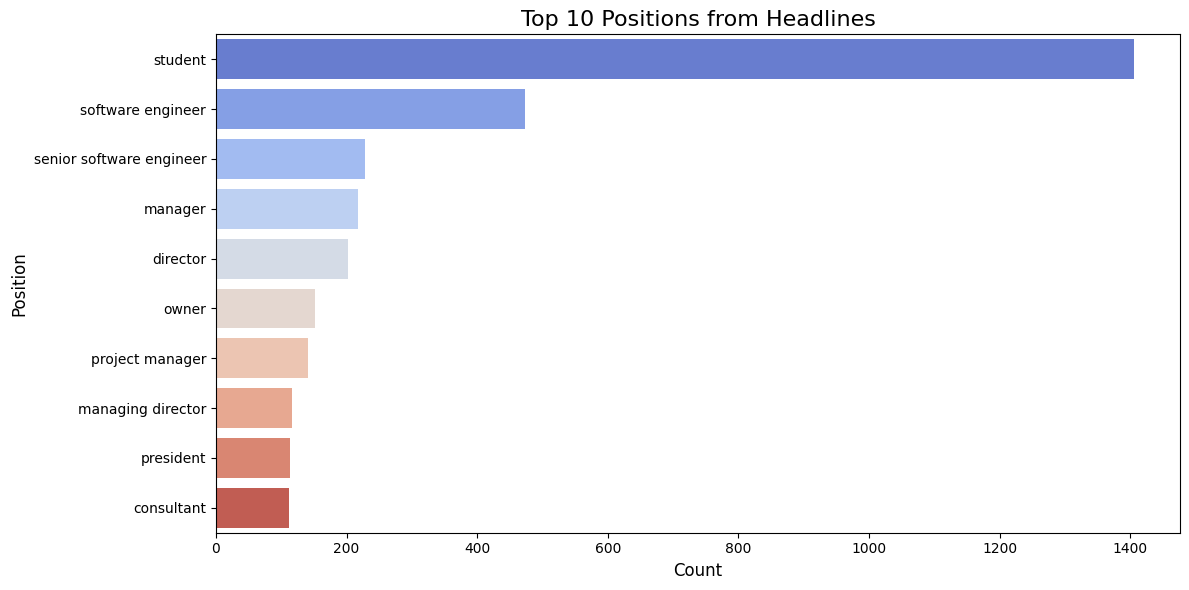

C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\3129030291.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_companies_pd, x="count", y="company", palette="viridis")


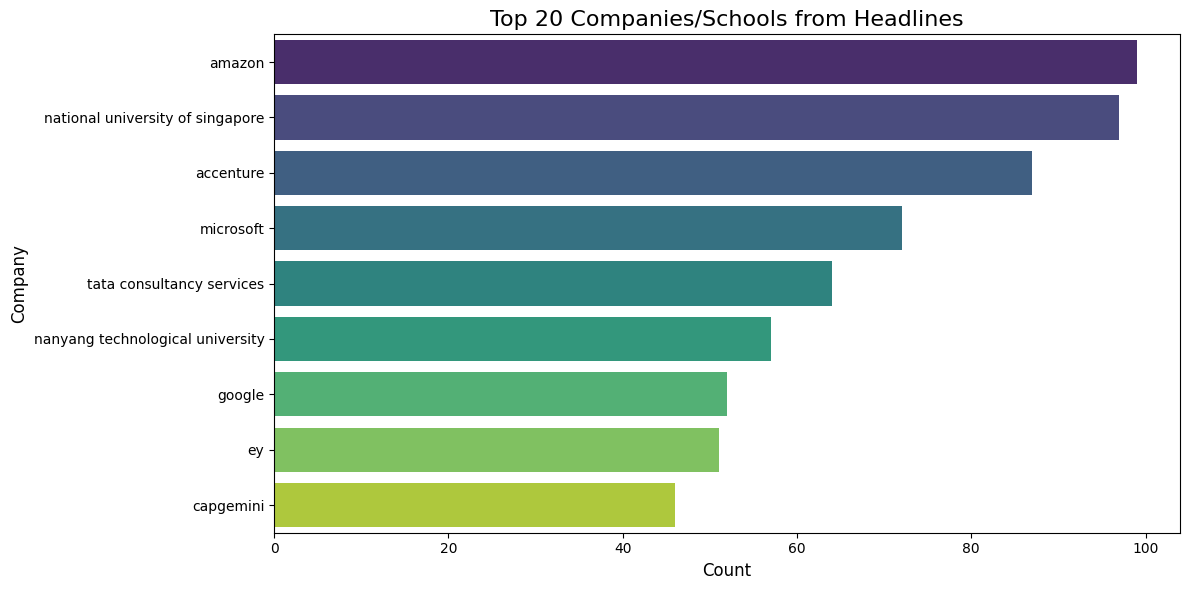

In [22]:
linkedin_f_df = linkedin_df.select(trim(lower(col("headline"))).alias("headline"))

linkedin_f_df = linkedin_f_df.withColumn(
    "position",
    trim(
        when(col("headline").contains(" at "), split(col("headline"), " at ").getItem(0))
        .when(col("headline").contains(" in "), split(col("headline"), " in ").getItem(0))
        .when(col("headline").contains(" working in "), split(col("headline"), " working in ").getItem(0))
        .otherwise(col("headline"))
    )
).withColumn(
    "company",
    trim(
        when(col("headline").contains(" at "), split(col("headline"), " at ").getItem(1))
        .when(col("headline").contains(" in "), split(col("headline"), " in ").getItem(1))
        .when(col("headline").contains(" working in "), split(col("headline"), " working in ").getItem(1))
        .otherwise(None)
    )
)

linkedin_f_df  = linkedin_f_df.filter(
    col("headline").isNotNull() & (col("headline") != "") & (col("headline") != "--")
)
linkedin_f_pd = linkedin_f_df.select("position", "company").toPandas()

output_file = "job_titles_and_companies.csv"
linkedin_f_pd.to_csv(output_file, index=False)

top_positions = linkedin_f_df.groupBy("position").count().orderBy(col("count").desc()).limit(10)
top_companies = linkedin_f_df.groupBy("company").count().orderBy(col("count").desc()).limit(10)

top_positions_pd = top_positions.toPandas()
top_companies_pd = top_companies.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_positions_pd, x="count", y="position", palette="coolwarm")
plt.title("Top 10 Positions from Headlines", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Position", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_companies_pd, x="count", y="company", palette="viridis")
plt.title("Top 20 Companies/Schools from Headlines", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Company", fontsize=12)
plt.tight_layout()
plt.show()

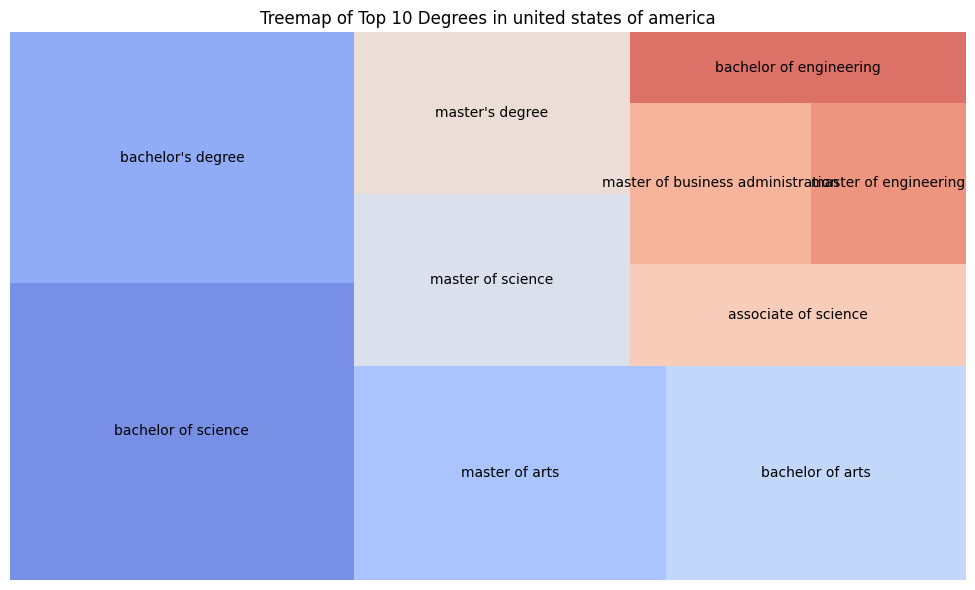

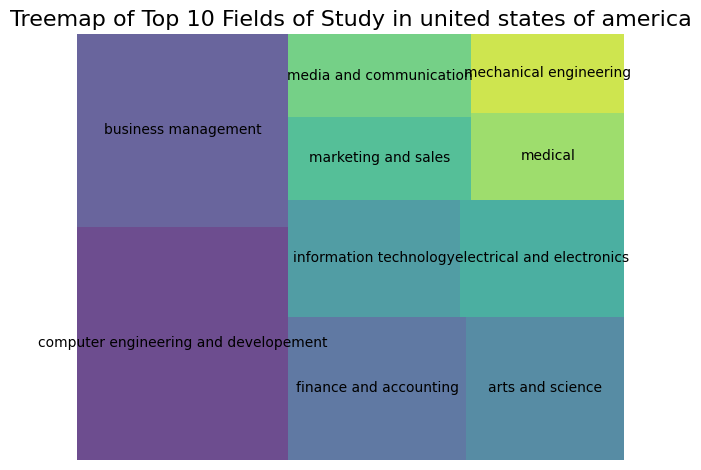

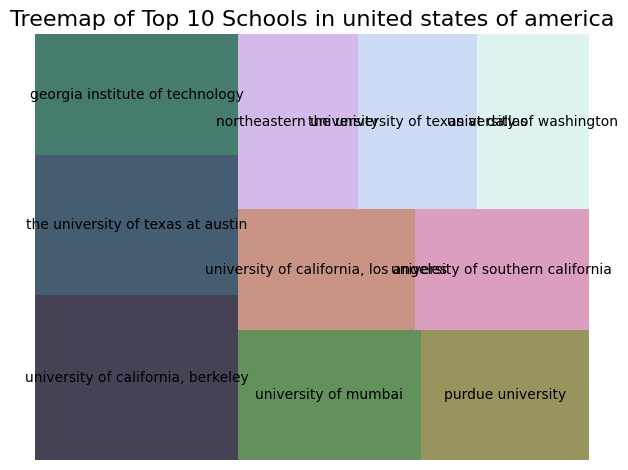

In [29]:
country_name = "united states of america"
linkedin_df_filtered = linkedin_df.filter(lower(col("country_full_name")) == country_name)
education_flat_df = linkedin_df_filtered.withColumn("education", explode(col("education")))

education_flat_df = education_flat_df.select(
    trim(lower(col("education.school"))).alias("school"),
    trim(lower(col("education.field_of_study"))).alias("field_of_study"),
    trim(lower(col("education.degree_name"))).alias("degree_name")
)


education_flat_df =  SetFields(education_flat_df)
education_flat_df =  SetDegree(education_flat_df)

degree_count = education_flat_df.groupBy("degree_name") \
    .agg(count("degree_name").alias("count")) \
    .orderBy(desc("count"))
degree_count_pd = degree_count.limit(10).toPandas()

plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=degree_count_pd["count"], 
    label=degree_count_pd["degree_name"], 
    color=sns.color_palette("coolwarm", len(degree_count_pd)), 
    alpha=0.8
)
plt.title(f"Treemap of Top 10 Degrees in {country_name}")
plt.axis('off')
plt.tight_layout()
plt.show()

field_count = education_flat_df.groupBy("field_of_study") \
    .agg(count("field_of_study").alias("count")) \
    .orderBy(desc("count"))
field_count_pd = field_count.limit(10).toPandas()
#plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=field_count_pd["count"], 
    label=field_count_pd["field_of_study"], 
    color=sns.color_palette("viridis", len(field_count_pd)), 
    alpha=0.8
)
plt.title(f"Treemap of Top 10 Fields of Study in {country_name}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

school_count = education_flat_df.groupBy("school") \
    .agg(count("school").alias("count")) \
    .orderBy(desc("count"))
school_count_pd = school_count.limit(10).toPandas()

#plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=school_count_pd["count"], 
    label=school_count_pd["school"], 
    color=sns.color_palette("cubehelix", len(school_count_pd)), 
    alpha=0.8
)
plt.title(f"Treemap of Top 10 Schools in {country_name}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

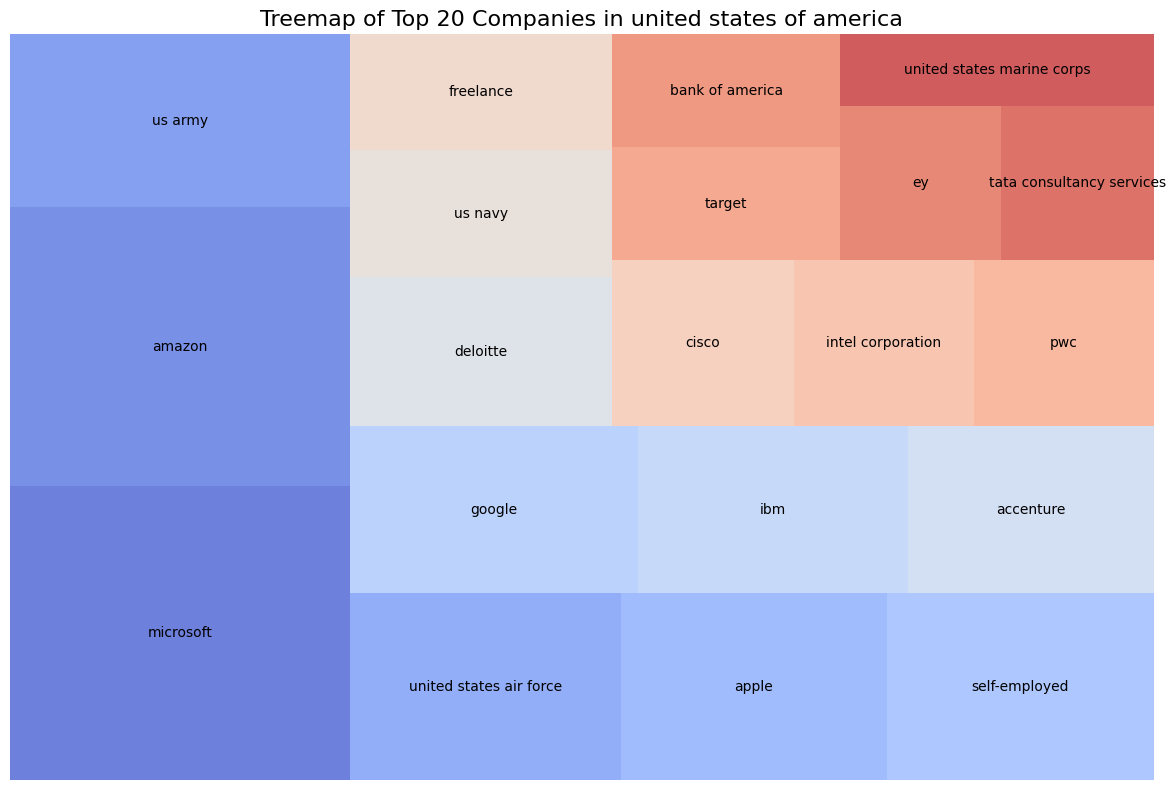

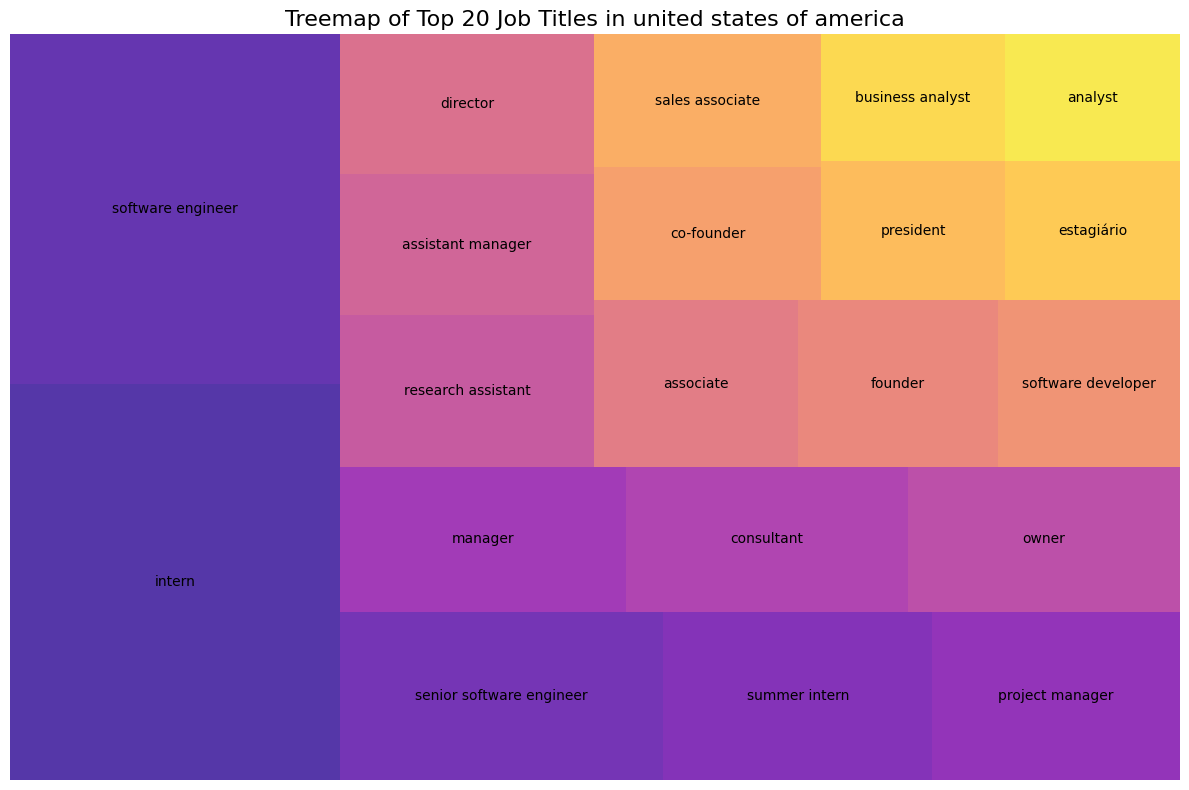

In [30]:
experience_flat_df = linkedin_df_filtered.withColumn("experiences", explode(col("experiences")))

experience_flat_df = experience_flat_df.select(
    trim(lower(col("experiences.company"))).alias("company"),
    trim(lower(col("experiences.title"))).alias("title")
)

company_count = experience_flat_df.groupBy("company") \
    .agg(count("company").alias("count")) \
    .orderBy(desc("count"))

company_count_pd = company_count.limit(20).toPandas()


plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=company_count_pd["count"], 
    label=company_count_pd["company"], 
    color=sns.color_palette("coolwarm", len(company_count_pd)), 
    alpha=0.8
)
plt.title(f"Treemap of Top 20 Companies in {country_name}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=title_count_pd["count"], 
    label=title_count_pd["title"], 
    color=sns.color_palette("plasma", len(title_count_pd)), 
    alpha=0.8
)
plt.title(f"Treemap of Top 20 Job Titles in {country_name}", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

C:\Users\Naman_Sharma\AppData\Local\Temp\ipykernel_4172\143883943.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5.loc[len(top_5)] = ['Other', other_sum]


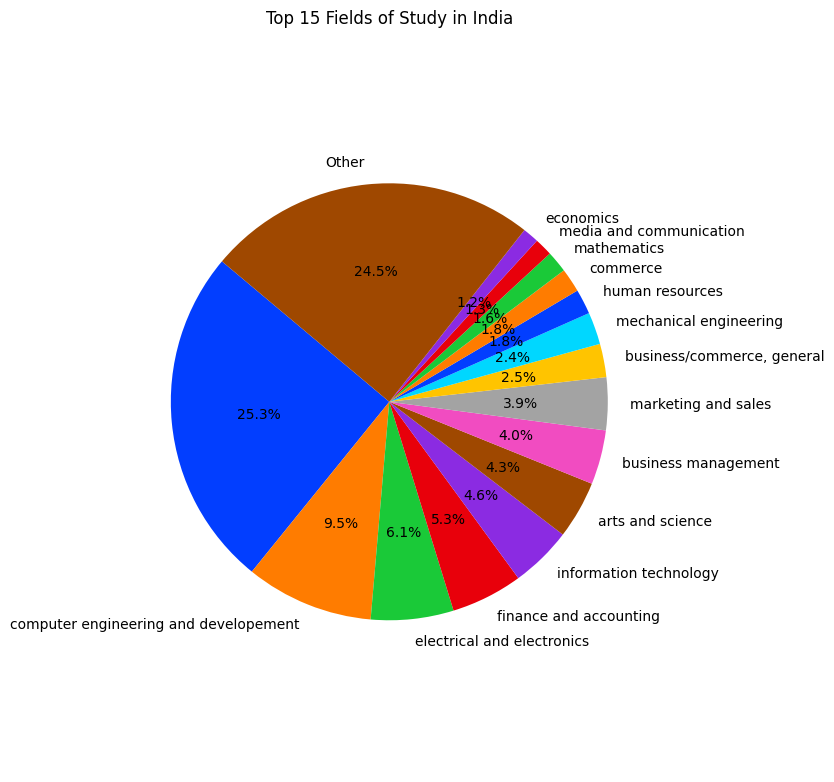

In [35]:
city_name = "india"
linkedin_df_filtered = linkedin_df.filter(lower(col("country_full_name")) == city_name)
education_flat_df = linkedin_df_filtered.withColumn("education", explode(col("education")))
education_flat_df = education_flat_df.select(
    trim(lower(col("education.field_of_study"))).alias("field_of_study")
)
education_flat_df = SetFields(education_flat_df)
field_count = education_flat_df.groupBy("field_of_study") \
    .count() \
    .orderBy(col("count").desc())
field_count_pd = field_count.toPandas()
top_5 = field_count_pd[:15]
other_sum = field_count_pd[15:]['count'].sum()
top_5.loc[len(top_5)] = ['Other', other_sum]  
palette_color = sns.color_palette('bright') 
plt.figure(figsize=(8, 8))
plt.pie(top_5['count'], labels=top_5['field_of_study'],colors=palette_color, autopct='%1.1f%%', startangle=140)
plt.title(f"Top 15 Fields of Study in {city_name.capitalize()}")
plt.axis('equal')  
plt.tight_layout()
plt.show()

In [32]:
company = "tata consultancy services"

In [33]:
linkedin_df_exploded = linkedin_df.withColumn("experiences", explode(col("experiences"))).withColumn(
    "education", explode(col("education"))
)

linkedin_cleaned_df = linkedin_df_exploded.select(
    trim(lower(col("education.school"))).alias("university"),
    trim(lower(col("experiences.company"))).alias("company_name")
)
tcs_employees_df = linkedin_cleaned_df.filter(
    col("company_name").like(f"%{company}%")
)
tcs_university_count = tcs_employees_df.groupBy("university") \
    .agg(count("*").alias("count")) \
    .orderBy(desc("count"))
total_employees = tcs_employees_df.count()
top_university = tcs_university_count.limit(5).toPandas()
print(f"University or Schools with the most students working at {company.capitalize()}:")
print(top_university["university"])

linkedin_cleaned_df = linkedin_df_exploded.select(
    trim(lower(col("education.degree_name"))).alias("degree_name"),
    trim(lower(col("experiences.company"))).alias("company_name")
)

linkedin_cleaned_df = linkedin_cleaned_df.filter(
    col("degree_name").isNotNull() & (col("degree_name") != "") &
    col("company_name").isNotNull() & (col("company_name") != "")
)

linkedin_cleaned_df = SetDegree(linkedin_cleaned_df)
tcs_employees_df = linkedin_cleaned_df.filter(
    col("company_name").like(f"%{company}%")
)
total_employees = tcs_employees_df.count()

tcs_university_count = tcs_employees_df.groupBy("degree_name") \
    .agg(count("*").alias("count")) \
    .orderBy(desc("count"))
top_university = tcs_university_count.limit(10).toPandas()
print()
print(f"Top Qualifications for Students Working at {company.capitalize()}:")
print(top_university["degree_name"])

linkedin_df_exploded = linkedin_df.withColumn("experiences", explode(col("experiences")))

skills_df = linkedin_df_exploded.filter(
    col("skills").isNotNull() & (size(col("skills")) > 0)  
).select(
    explode(col("skills")).alias("skill"),  
    trim(lower(col("experiences.company"))).alias("company_name")  
).filter(
    col("company_name").like(f"%{company}%")  
)

top_skills_df = skills_df.groupBy("skill").agg(count("*").alias("count")).orderBy(col("count").desc())

top_20_skills = top_skills_df.limit(20).toPandas()

print(f"\nTop 20 skills for employees working at {company.capitalize()}:")
print(top_20_skills["skill"])

University or Schools with the most students working at Tata consultancy services:
0                   university of mumbai
1    great lakes institute of management
2                        anna university
3                         srm university
4                     kendriya vidyalaya
Name: university, dtype: object

Top Qualifications for Students Working at Tata consultancy services:
0               bachelor of technology
1              bachelor of engineering
2                    bachelor's degree
3    master of business administration
4                          high school
5                      master's degree
6                       master of arts
7                  bachelor of science
8                master of engineering
9                 master of technology
Name: degree_name, dtype: object

Top 20 skills for employees working at Tata consultancy services:
0                       sql
1          microsoft office
2                         c
3           microsoft excel
4      

In [34]:
linkedin_df_exploded = linkedin_df.withColumn("experiences",explode(col("experiences"))).withColumn(
    "education", explode(col("education"))
)

linkedin_cleaned_df = linkedin_df_exploded.select(
    trim(lower(col("education.degree_name"))).alias("degree_name"),
    trim(lower(col("experiences.company"))).alias("company_name")
)

linkedin_cleaned_df = linkedin_cleaned_df.filter(
    col("degree_name").isNotNull() & (col("degree_name") != "") &
    col("company_name").isNotNull() & (col("company_name") != "")
)

linkedin_cleaned_df = SetDegree(linkedin_cleaned_df)
tcs_employees_df = linkedin_cleaned_df.filter(
    col("company_name").like(f"%{company}%")
)
total_employees = tcs_employees_df.count()
print(total_employees)

tcs_university_count = tcs_employees_df.groupBy("degree_name") \
    .agg(count("*").alias("count")) \
    .orderBy(desc("count"))
top_university = tcs_university_count.limit(2).toPandas()
print("Top Qualifications Students Working at TCS")
print(top_university)

top_10_degree = tcs_university_count.limit(10).toPandas()

1209
Top Qualifications Students Working at TCS
               degree_name  count
0   bachelor of technology    236
1  bachelor of engineering    169


In [ ]:
# spark.stop()